#### Librairies et lecture des jeux de données

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

import random
import argparse
from torch.serialization import save
from scipy import stats
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt
from scipy import stats

from kmembert.models import HealthBERT
from kmembert.utils import create_session

In [2]:
# Import argparse
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")
parser.add_argument("-nr", "--nrows", type=int, default=10, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
parser.add_argument("-ng", "--noigr", type=int, default=2, 
    help="The Noigr of a patient")
args = parser.parse_args("")

In [3]:
# Read df used to test
# Creation du jeu de donnees pour retrouver les infos interessantes
test = pd.read_csv("kmembert\\Visualization\\test_VM.csv")

# Read df with prediction
res_pred = pd.read_csv("kmembert\\Visualization\\results_pred_VM.csv")

# Merge 2 dataframes
resul_df = pd.merge(test, res_pred, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab']]

# Add columns to have absolute error between pred and lab
resul_df['ecart'] = abs(resul_df['pred']-resul_df['lab'])

resul_df['nb_words'] = resul_df['Texte'].apply(lambda x: len(x.split()))

resul_df['nb_docs'] = resul_df.groupby(["Noigr"])["Noigr"].transform("count")

resul_df = resul_df.sort_values("ecart", ascending=False)

#### Modification du jeu de données

In [4]:
# Lecture du jeu de données qui a permis de faire les predictions
test = pd.read_csv("data\\result_PS\\test_withPS.csv")
test.head(4)

,Noigr,Date cr,Date deces,Texte,PS_flag,indice
0,6035881,20041004,20120922,"Karnofsky = 100 %, PS = 0. Evolutivité de la m...",PS=0,0
1,6035881,20051026,20120922,"Karnofsky = 100 %, PS = 0. Se plaint depuis la...",PS=0,1
2,6035881,20051121,20120922,"Karnofsky = 100 %, PS = 0. Evolutivité de la m...",PS=0,2
3,12448542,20170928,20171208,"Karnofsky = 80 %, PS = 1. Diagnostic : Carcin...",PS=1,3


In [5]:
# Create artificial dataset with prediction and lab for case without PS and Kar
'''pred = np.random.uniform(0, 1, len(test))
lab = np.random.uniform(0, 1, len(test))
res_pred_PS = pd.DataFrame({"ind":test['indice'], "pred":pred, "lab":lab})'''
res_pred_PS = pd.read_csv("data\\result_PS\\resu_pred_noPS.csv")

# Create artificial dataset with prediction and lab for case with PS and Kar
'''pred2 = np.random.uniform(0, 1, len(test))
lab2 = np.random.uniform(0, 1, len(test))
res_pred_withPS = pd.DataFrame({"ind":test['indice'], "pred":pred2, "lab":lab2})'''
res_pred_withPS = pd.read_csv("data\\result_PS\\resu_pred_withPS.csv")

In [6]:
# Merge and add prediction and label

# Merge 2 dataframes : test with res_pred_PS (without PS)
resul_df = pd.merge(test, res_pred_PS, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab', 'PS_flag']]
resul_df.rename(columns = {'pred':'pred_PS'}, inplace = True) # Rename columns

# Merge 2 dataframes : test with res_pred_withPS (with PS)
resul_df = pd.merge(resul_df, res_pred_withPS, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'lab_x', 'pred_PS', 'pred', 'PS_flag']]
resul_df.rename(columns = {'lab_x':'lab'}, inplace = True) # Rename columns
resul_df.rename(columns = {'pred':'pred_withPS'}, inplace = True) # Rename columns

resul_df.head(4)

,Noigr,Date cr,Date deces,Texte,indice,lab,pred_PS,pred_withPS,PS_flag
0,6035881,20041004,20120922,"Karnofsky = 100 %, PS = 0. Evolutivité de la m...",0,0.973682,0.841842,0.880029,PS=0
1,6035881,20051026,20120922,"Karnofsky = 100 %, PS = 0. Se plaint depuis la...",1,0.957308,0.602624,0.680463,PS=0
2,6035881,20051121,20120922,"Karnofsky = 100 %, PS = 0. Evolutivité de la m...",2,0.955898,0.377717,0.646344,PS=0
3,12448542,20170928,20171208,"Karnofsky = 80 %, PS = 1. Diagnostic : Carcin...",3,0.495910,0.346177,0.457618,PS=1


### BoxPlot with labels and prediction (with/without PS and Kar)

In [7]:
# Pre-Processing for the plot

# Number of elements in each PS
len_PS0 = len(resul_df[resul_df.PS_flag=="PS=0"])
len_PS1 = len(resul_df[resul_df.PS_flag=="PS=1"])
len_PS2 = len(resul_df[resul_df.PS_flag=="PS=2"])
len_PS3 = len(resul_df[resul_df.PS_flag=="PS=3"])
len_PS4 = len(resul_df[resul_df.PS_flag=="PS=4"])

##### BarPlot of number of elements per PS

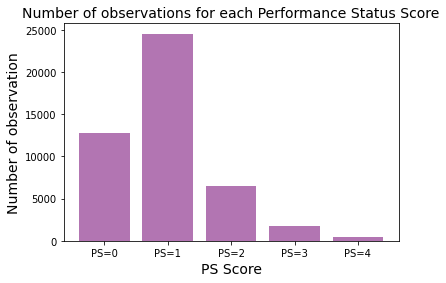

In [8]:
height = [len_PS0, len_PS1, len_PS2, len_PS3, len_PS4]
bars = ('PS=0', 'PS=1', 'PS=2', 'PS=3', 'PS=4')
x_pos = np.arange(len(bars))
 
# Create bars and choose color
plt.bar(x_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Number of observations for each Performance Status Score', fontsize=14)
plt.xlabel('PS Score', fontsize=14)
plt.ylabel('Number of observation', fontsize=14)
 
# Create names on the x axis
plt.xticks(x_pos, bars)

# Save the fig
plt.savefig("graphs\\data_viz_clb\\barplot_count.png", bbox_inches='tight')

##### BoxPlot

TypeError: Got both 'fontsize' and 'size', which are aliases of one another

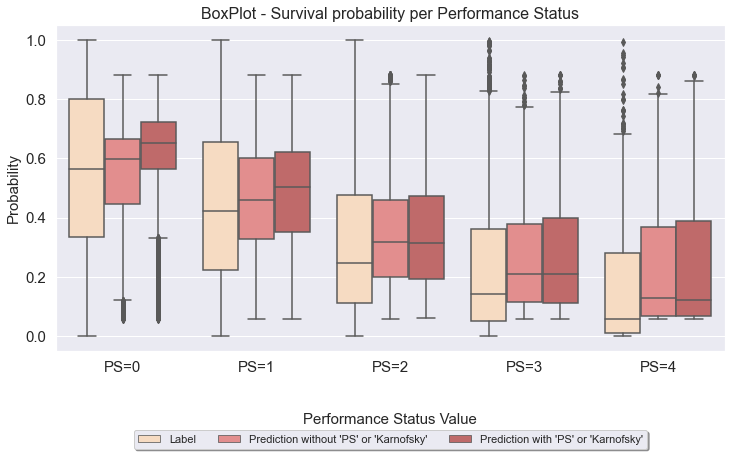

In [9]:
# BoxPlot - Survival Time per PS - Prediction and Observed Label
sns.set(rc={'figure.figsize':(12,6)})

fig = plt.figure()
ax = plt.subplot(111)

# Ajustement du jeu de données
df_plot = resul_df.melt(id_vars='PS_flag', value_vars=["lab", "pred_PS", "pred_withPS"])
df_plot['variable'] = df_plot['variable'].replace('lab', 'Label')
df_plot['variable'] = df_plot['variable'].replace('pred_PS', "Prediction without 'PS' or 'Karnofsky'")
df_plot['variable'] = df_plot['variable'].replace('pred_withPS', "Prediction with 'PS' or 'Karnofsky'")

# Plot
ax = sns.boxplot(x='PS_flag', y='value', hue='variable', data=df_plot, 
            order=['PS=0', 'PS=1', 'PS=2', 'PS=3', 'PS=4'], palette=['peachpuff', 'lightcoral', 'indianred'])#'rocket_r')
plt.xlabel("Performance Status Value", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.title("BoxPlot - Survival probability per Performance Status", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.225),
          fancybox=True, shadow=True, ncol=5)
ax.xaxis.set_label_coords(0.5, -0.19)
# Plot text
plt.text(-0.1, -0.205, len_PS0, fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.1+0.95, -0.205, len_PS1, fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+2.05, -0.205, len_PS2, fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+3.05, -0.205, len_PS3, fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.175+4.075, -0.205, len_PS4, fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))

plt.savefig("graphs\\data_viz_clb\\boxplot_survival.png", bbox_inches='tight')

##### Krustal Test for labels, pred PS, pred without PS over PS

In [10]:
# Test Statistique sur les différences de temps de survie des patients : Valeures observees

for type in ['lab', 'pred_PS', 'pred_withPS']:

    # Get values separated per PS for the given type
    a = resul_df[resul_df.PS_flag=='PS=0'][type]
    b = resul_df[resul_df.PS_flag=='PS=1'][type]
    c = resul_df[resul_df.PS_flag=='PS=2'][type]
    d = resul_df[resul_df.PS_flag=='PS=3'][type]
    e = resul_df[resul_df.PS_flag=='PS=4'][type]

    print("For type: " + type)
    print("Kruskal, pvalue for: ", stats.kruskal(a, b, c, d, e))
    print("Anova, pvalue:", stats.f_oneway(a, b, c, e, e), "\n")

For type: lab
Kruskal, pvalue for:  KruskalResult(statistic=5022.606938078142, pvalue=0.0)
Anova, pvalue: F_onewayResult(statistic=1158.8292417075816, pvalue=0.0) 

For type: pred_PS
Kruskal, pvalue for:  KruskalResult(statistic=7801.272205355826, pvalue=0.0)
Anova, pvalue: F_onewayResult(statistic=2122.210438358387, pvalue=0.0) 

For type: pred_withPS
Kruskal, pvalue for:  KruskalResult(statistic=11033.556127947622, pvalue=0.0)
Anova, pvalue: F_onewayResult(statistic=3201.7107050618793, pvalue=0.0) 



#### Etude des corrélations

In [11]:
# Correlation entre labels et prediction avec PS
print("Correlation entre observations et predictions sans PS: ", np.corrcoef(resul_df['lab'], resul_df['pred_PS'])[0,1])
print("Correlation entre observations et predictions avec PS: ", np.corrcoef(resul_df['lab'], resul_df['pred_withPS'])[0,1])
print("Correlation entre predictions sans PS et predictions avec PS: ", np.corrcoef(resul_df['pred_PS'], resul_df['pred_withPS'])[0,1])

Correlation entre observations et predictions sans PS:  0.5946113525670965
Correlation entre observations et predictions avec PS:  0.6006325930538317
Correlation entre predictions sans PS et predictions avec PS:  0.9743253481723275


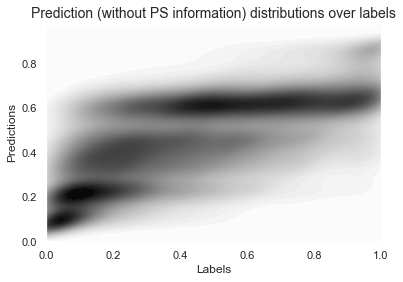

In [12]:
# Affichage : Label en fonction de predictions sans PS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set(rc={'figure.figsize':(6,4)})

n_points = 20
resize_factor = 20

sns.kdeplot(
    data={'Predictions': resul_df['pred_PS'], 'Labels': resul_df['lab']}, 
    y='Predictions', x='Labels', clip=((0, 1), (0, 1)),
    fill=True, thresh=0, levels=100, cmap=cm.gray_r
)
plt.title('Prediction (without PS information) distributions over labels', fontsize=14)
plt.savefig("graphs\\data_viz_clb\\density_pred_noPS.png", bbox_inches='tight')

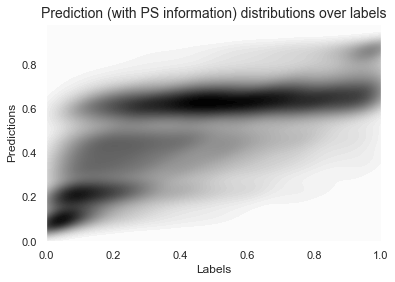

In [13]:
# Affichage : Label en fonction de predictions avec PS
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_points = 20
resize_factor = 20

sns.kdeplot(
    data={'Predictions': resul_df['pred_withPS'], 'Labels': resul_df['lab']}, 
    y='Predictions', x='Labels', clip=((0, 1), (0, 1)),
    fill=True, thresh=0, levels=100, cmap=cm.gray_r
)
plt.title('Prediction (with PS information) distributions over labels', fontsize=14)
plt.savefig("graphs\\data_viz_clb\\density_pred_withPS.png", bbox_inches='tight')

### Others Plots

In [14]:
# Moyenne du nombre de jours en label
def time_survival_to_label(time_survival, mean_time_survival):
    """
    Transforms times of survival into uniform labels in ]0,1[
    """
    return 1 - np.exp(-time_survival/mean_time_survival)

mean_label = time_survival_to_label(800, 800)

In [15]:
threshold_label = time_survival_to_label(701, 800)
resul_df['flag_pred'] = resul_df['pred_withPS'].apply(lambda x: 1*(x>=threshold_label))
resul_df['flag_lab'] = resul_df['lab'].apply(lambda x: 1*(x>=threshold_label))
resul_df_correct_pred = resul_df[resul_df.flag_lab==resul_df.flag_pred]

c:\Users\DIPIAZZA\Anaconda3\envs\clb_env2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DIPIAZZA\Anaconda3\envs\clb_env2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DIPIAZZA\Anaconda3\envs\clb_env2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

Text(0.5, 1.0, 'Density plot of survival scores')

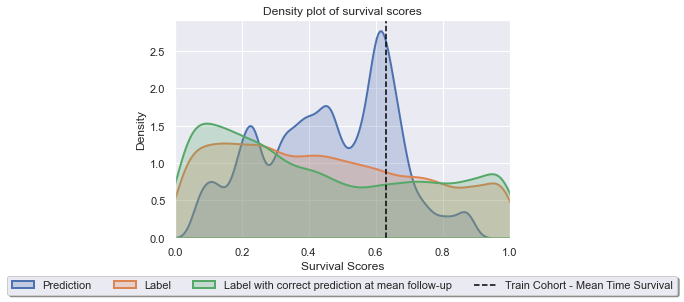

In [16]:
# Density Plot
fig = plt.figure()
ax = plt.subplot(111)

sns.distplot(resul_df['pred_PS'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = "Prediction")

sns.distplot(resul_df['lab'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = "Label")

sns.distplot(resul_df_correct_pred['lab'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = "Label with correct prediction at mean follow-up")

plt.axvline(x=mean_label, ls='--', color="black", label="Train Cohort - Mean Time Survival")


plt.xlim([0, 1])
plt.xlabel("Survival Scores")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
          
plt.title("Density plot of survival scores")
#plt.savefig("graphs\\data_viz_clb\\dens_scores.png")

### Plot per PS

In [17]:
resul_df.head(2)

,Noigr,Date cr,Date deces,Texte,indice,lab,pred_PS,pred_withPS,PS_flag,flag_pred,flag_lab
0,6035881,20041004,20120922,"Karnofsky = 100 %, PS = 0. Evolutivité de la m...",0,0.973682,0.841842,0.880029,PS=0,1,1
1,6035881,20051026,20120922,"Karnofsky = 100 %, PS = 0. Se plaint depuis la...",1,0.957308,0.602624,0.680463,PS=0,1,1


In [20]:
# Add 2 columns : pred_PS_class, pred_withPS_class which indicates interval of prediction
conditions = [
    (resul_df['pred_PS'] <= 0.2),
    (resul_df['pred_PS'] > 0.2) & (resul_df['pred_PS'] <= 0.4),
    (resul_df['pred_PS'] > 0.4) & (resul_df['pred_PS'] <= 0.6),
    (resul_df['pred_PS'] > 0.6) & (resul_df['pred_PS'] <= 0.8),
    (resul_df['pred_PS'] > 0.8)
    ]
conditions_with = [
    (resul_df['pred_withPS'] <= 0.2),
    (resul_df['pred_withPS'] > 0.2) & (resul_df['pred_withPS'] <= 0.4),
    (resul_df['pred_withPS'] > 0.4) & (resul_df['pred_withPS'] <= 0.6),
    (resul_df['pred_withPS'] > 0.6) & (resul_df['pred_withPS'] <= 0.8),
    (resul_df['pred_withPS'] > 0.8)
    ]
conditions_lab = [
    (resul_df['lab'] <= 0.2),
    (resul_df['lab'] > 0.2) & (resul_df['lab'] <= 0.4),
    (resul_df['lab'] > 0.4) & (resul_df['lab'] <= 0.6),
    (resul_df['lab'] > 0.6) & (resul_df['lab'] <= 0.8),
    (resul_df['lab'] > 0.8)
    ]

# create a list of the values we want to assign for each condition
values = ['[0-2]', '[2-4]', '[4-6]', '[6-8]', '[8-10]']

# create a new column and use np.select to assign values to it using our lists as arguments
resul_df['pred_PS_class'] = np.select(conditions, values)
resul_df['pred_withPS_class'] = np.select(conditions_with, values)
resul_df['lab_class'] = np.select(conditions_lab, values)
resul_df.head(2)

,Noigr,Date cr,Date deces,Texte,indice,lab,pred_PS,pred_withPS,PS_flag,flag_pred,flag_lab,pred_PS_class,pred_withPS_class,lab_class
0,6035881,20041004,20120922,"Karnofsky = 100 %, PS = 0. Evolutivité de la m...",0,0.973682,0.841842,0.880029,PS=0,1,1,[8-10],[8-10],[8-10]
1,6035881,20051026,20120922,"Karnofsky = 100 %, PS = 0. Se plaint depuis la...",1,0.957308,0.602624,0.680463,PS=0,1,1,[6-8],[6-8],[8-10]


#### Confusion Matrix

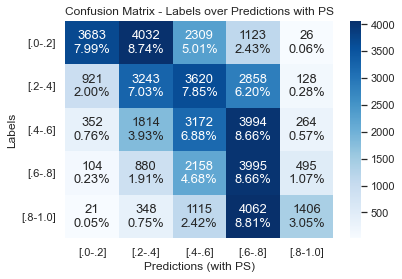

In [91]:
# Prediction AVEC PS vs LABEL
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_true = resul_df['lab_class']
y_pred = resul_df['pred_withPS_class']

array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(5), range(5))
cf_matrix = array

fig = plt.figure()
ax = plt.subplot(111)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":13})

ax.set_xlabel('Predictions (with PS)');ax.set_ylabel('Labels'); 
ax.set_title('Confusion Matrix - Labels over Predictions with PS'); 
ax.xaxis.set_ticklabels(['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]'])
ax.yaxis.set_ticklabels(['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]'], rotation = 0)

plt.savefig("graphs\\data_viz_clb\\conf_mat_labels_over_PS.png", bbox_inches = 'tight')

In [92]:
#### Calcul et affichage des métriques pour cette table de confusion
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

print(classification_report(y_true, y_pred, digits=3))

print("\n Cohen Kappa Score: ", cohen_kappa_score(y_true, y_pred))

print("\n Accuracy Score: ", accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

       [0-2]      0.725     0.330     0.453     11173
       [2-4]      0.314     0.301     0.308     10770
       [4-6]      0.256     0.331     0.289      9596
       [6-8]      0.249     0.523     0.338      7632
      [8-10]      0.606     0.202     0.303      6952

    accuracy                          0.336     46123
   macro avg      0.430     0.337     0.338     46123
weighted avg      0.435     0.336     0.343     46123


 Cohen Kappa Score:  0.17022245096032107

 Accuracy Score:  0.33603625089434774


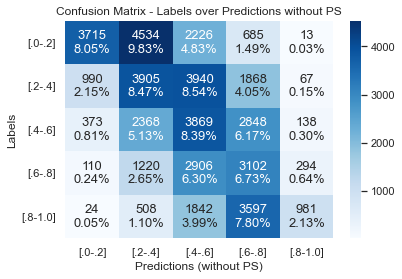

In [75]:
# Prediction LAVEL VS SANS PS
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_true = resul_df['lab_class']
y_pred = resul_df['pred_PS_class']

array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(5), range(5))
cf_matrix = array

fig = plt.figure()
ax = plt.subplot(111)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":13})

ax.set_xlabel('Predictions (without PS)');ax.set_ylabel('Labels'); 
ax.set_title('Confusion Matrix - Labels over Predictions without PS');
x_labels = ['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]']; 
y_labels = ['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]']; 
ax.xaxis.set_ticklabels(x_labels)
ax.yaxis.set_ticklabels(y_labels, rotation = 0)

plt.savefig("graphs\\data_viz_clb\\conf_mat_labels_over_noPS.png", bbox_inches = 'tight')

In [76]:
#### Calcul et affichage des métriques pour cette table de confusion
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

print(classification_report(y_true, y_pred, digits=3))

print("\n Cohen Kappa Score: ", cohen_kappa_score(y_true, y_pred))

              precision    recall  f1-score   support

       [0-2]      0.713     0.332     0.453     11173
       [2-4]      0.312     0.363     0.335     10770
       [4-6]      0.262     0.403     0.317      9596
       [6-8]      0.256     0.406     0.314      7632
      [8-10]      0.657     0.141     0.232      6952

    accuracy                          0.338     46123
   macro avg      0.440     0.329     0.331     46123
weighted avg      0.441     0.338     0.341     46123


 Cohen Kappa Score:  0.16596960681231876


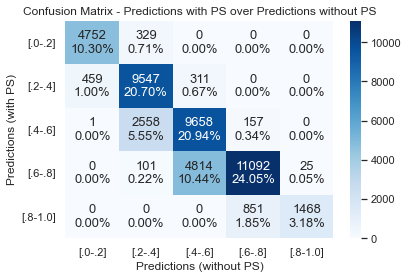

In [78]:
# Prediction SANS PS vs AVEC PS
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_true = resul_df['pred_withPS_class']
y_pred = resul_df['pred_PS_class']

array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(5), range(5))
cf_matrix = array

fig = plt.figure()
ax = plt.subplot(111)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":13})

ax.set_xlabel('Predictions (without PS)');ax.set_ylabel('Predictions (with PS)'); 
ax.set_title('Confusion Matrix - Predictions with PS over Predictions without PS'); 
ax.xaxis.set_ticklabels(['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]'])
ax.yaxis.set_ticklabels(['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]'], rotation = 0)

plt.show()

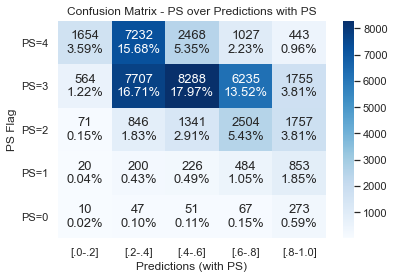

In [26]:
# Confusion matrix between : PS_Flag and prediction with PS
# Get data of 3 columns : lab, pred with PS and pred without PS
y_lab = resul_df['lab_class']
y_noPS = resul_df['pred_PS_class']
y_PS = resul_df['pred_withPS_class']
y_PS_flag = resul_df['PS_flag']

if(True):
    y_PS = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_lab))
    y_PS = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_lab))
    y_PS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_lab))
    y_PS = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_lab))
    y_PS = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_lab))
    y_PS = pd.Series(y_PS)
    y_noPS = pd.Series(y_noPS)
    y_lab = pd.Series(y_lab)

array = confusion_matrix(y_PS_flag, y_PS)
df_cm = pd.DataFrame(array, range(5), range(5))
cf_matrix = array

fig = plt.figure()
ax = plt.subplot(111)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":13})

ax.set_ylabel('PS Flag');ax.set_xlabel('Predictions (with PS)'); 
ax.set_title('Confusion Matrix - PS over Predictions with PS'); 
ax.xaxis.set_ticklabels(['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]'])
ax.yaxis.set_ticklabels(['PS=4', 'PS=3', 'PS=2', 'PS=1', 'PS=0'], rotation = 0)

plt.savefig("graphs\\data_viz_clb\\conf_mat_PSflag_over_PS.png", bbox_inches = 'tight')

In [27]:
#### Calcul et affichage des métriques pour cette table de confusion
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

print(classification_report(y_PS_flag, y_PS, digits=3))

print("\n Cohen Kappa Score: ", cohen_kappa_score(y_true, y_pred))

              precision    recall  f1-score   support

        PS=0      0.713     0.129     0.218     12824
        PS=1      0.481     0.314     0.380     24549
        PS=2      0.108     0.206     0.142      6519
        PS=3      0.047     0.271     0.080      1783
        PS=4      0.054     0.609     0.099       448

    accuracy                          0.248     46123
   macro avg      0.281     0.306     0.184     46123
weighted avg      0.472     0.248     0.287     46123


 Cohen Kappa Score:  0.721549040133778


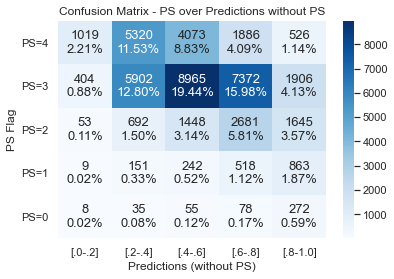

In [28]:
# Confusion matrix between : PS_Flag and prediction without PS
# Get data of 3 columns : lab, pred with PS and pred without PS
y_lab = resul_df['lab_class']
y_noPS = resul_df['pred_PS_class']
y_PS = resul_df['pred_withPS_class']
y_PS_flag = resul_df['PS_flag']

if(True):
    y_PS = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_lab))
    y_PS = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_lab))
    y_PS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_lab))
    y_PS = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_lab))
    y_PS = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_lab))
    y_PS = pd.Series(y_PS)
    y_noPS = pd.Series(y_noPS)
    y_lab = pd.Series(y_lab)

array = confusion_matrix(y_PS_flag, y_noPS)
df_cm = pd.DataFrame(array, range(5), range(5))
cf_matrix = array

fig = plt.figure()
ax = plt.subplot(111)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":13})

ax.set_ylabel('PS Flag');ax.set_xlabel('Predictions (without PS)'); 
ax.set_title('Confusion Matrix - PS over Predictions without PS'); 
ax.xaxis.set_ticklabels(['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]'])
ax.yaxis.set_ticklabels(['PS=4', 'PS=3', 'PS=2', 'PS=1', 'PS=0'], rotation = 0)

plt.savefig("graphs\\data_viz_clb\\conf_mat_PSflag_over_noPS.png", bbox_inches = 'tight')

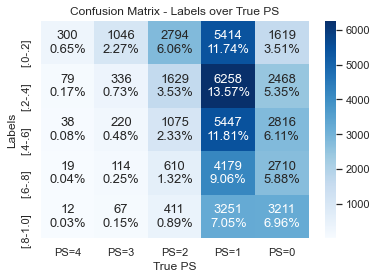

In [94]:
# Confusion matrix between : LABELS VS PS_FLAG
y_lab = resul_df['lab_class']
y_PS_flag = resul_df['PS_flag']

if(True):
    y_lab = list(map(lambda x: x.replace('[0-2]', 'PS=4'), y_lab))
    y_lab = list(map(lambda x: x.replace('[2-4]', 'PS=3'), y_lab))
    y_lab = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_lab))
    y_lab = list(map(lambda x: x.replace('[6-8]', 'PS=1'), y_lab))
    y_lab = list(map(lambda x: x.replace('[8-10]', 'PS=0'), y_lab))
    y_lab = pd.Series(y_lab)

array = confusion_matrix(y_lab, y_PS_flag, labels=['PS=4', 'PS=3', 'PS=2', 'PS=1', 'PS=0'])
df_cm = pd.DataFrame(array, range(5), range(5))
cf_matrix = array

fig = plt.figure()
ax = plt.subplot(111)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":13})

ax.set_ylabel('Labels');ax.set_xlabel('True PS'); 
ax.set_title('Confusion Matrix - Labels over True PS'); 
y_labels = ['[.0-.2]', '[.2-.4]', '[.4-.6]', '[.6-.8]', '[.8-1.0]']
x_labels = ['PS=4', 'PS=3', 'PS=2', 'PS=1', 'PS=0']
ax.yaxis.set_ticklabels(y_labels)
ax.xaxis.set_ticklabels(x_labels, rotation = 0)

plt.savefig("graphs\\data_viz_clb\\conf_mat_LABELS_over_truePS.png", bbox_inches = 'tight')

In [96]:
#### Calcul et affichage des métriques pour cette table de confusion
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report

print(classification_report(y_lab, y_PS_flag, digits=3))

print("\n Cohen Kappa Score: ", cohen_kappa_score(y_lab, y_PS_flag))

print("\n Accuracy Score: ", accuracy_score(y_lab, y_PS_flag))

              precision    recall  f1-score   support

        PS=0      0.250     0.462     0.325      6952
        PS=1      0.170     0.548     0.260      7632
        PS=2      0.165     0.112     0.133      9596
        PS=3      0.188     0.031     0.054     10770
        PS=4      0.670     0.027     0.052     11173

    accuracy                          0.197     46123
   macro avg      0.289     0.236     0.165     46123
weighted avg      0.306     0.197     0.145     46123


 Cohen Kappa Score:  0.032022945870524344

 Accuracy Score:  0.19732020900635258


### Test statistique pour comparer les 3 classes

#### V of Cramer

In [29]:
# Compute V of Cramer

# Get data of 3 columns : lab, pred with PS and pred without PS
y_lab = resul_df['lab_class']
y_noPS = resul_df['pred_PS_class']
y_PS = resul_df['pred_withPS_class']
y_PS_flag = resul_df['PS_flag']

# V of Cramer between LABELS and with PS
if(True):
    dataset = confusion_matrix(y_lab, y_PS)
    df_cm = pd.DataFrame(array, range(5), range(5))
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1
    result = np.sqrt((X2/N) / minimum_dimension)
    print("V of Cramer between LABELS and with PS: ", result)

# V of Cramer between LABELS and without PS
if(True):
    dataset = confusion_matrix(y_lab, y_noPS)
    df_cm = pd.DataFrame(array, range(5), range(5))
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1
    result = np.sqrt((X2/N) / minimum_dimension)
    print("V of Cramer between LABELS and without PS: ", result)

# V of Cramer between with and without PS
if(True):
    dataset = confusion_matrix(y_noPS, y_PS)
    df_cm = pd.DataFrame(array, range(5), range(5))
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1
    result = np.sqrt((X2/N) / minimum_dimension)
    print("V of Cramer between without and with PS: ", result)

# Replace interval by PS to match for confusion matrix
if(True):
    y_PS = list(map(lambda x: x.replace('[0-2]', 'PS=0'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[0-2]', 'PS=0'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[0-2]', 'PS=0'), y_lab))
    y_PS = list(map(lambda x: x.replace('[2-4]', 'PS=1'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[2-4]', 'PS=1'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[2-4]', 'PS=1'), y_lab))
    y_PS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_lab))
    y_PS = list(map(lambda x: x.replace('[6-8]', 'PS=3'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[6-8]', 'PS=3'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[6-8]', 'PS=3'), y_lab))
    y_PS = list(map(lambda x: x.replace('[8-10]', 'PS=4'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[8-10]', 'PS=4'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[8-10]', 'PS=4'), y_lab))
    y_PS = pd.Series(y_PS)
    y_noPS = pd.Series(y_noPS)
    y_lab = pd.Series(y_lab)
    
# V of Cramer between PS_Flag and labels
if(True):
    dataset = confusion_matrix(y_PS_flag, y_lab)
    df_cm = pd.DataFrame(array, range(5), range(5))
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1
    result = np.sqrt((X2/N) / minimum_dimension)
    print("V of Cramer between PS_Flag and LABELS: ", result)

# V of Cramer between PS_Flag and with PS
if(True):
    dataset = confusion_matrix(y_PS_flag, y_PS)
    df_cm = pd.DataFrame(array, range(5), range(5))
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1
    result = np.sqrt((X2/N) / minimum_dimension)
    print("V of Cramer between PS_Flag and with PS: ", result)

# V of Cramer between PS_Flag and without PS
if(True):
    dataset = confusion_matrix(y_PS_flag, y_noPS)
    df_cm = pd.DataFrame(array, range(5), range(5))
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1
    result = np.sqrt((X2/N) / minimum_dimension)
    print("V of Cramer between PS_Flag and without PS: ", result)

V of Cramer between LABELS and with PS:  0.3161899893172254
V of Cramer between LABELS and without PS:  0.30957831988728124
V of Cramer between without and with PS:  0.7899907702475855
V of Cramer between PS_Flag and LABELS:  0.1680462497764334
V of Cramer between PS_Flag and with PS:  0.27564502312122846
V of Cramer between PS_Flag and without PS:  0.23628078302295352


#### Khi 2

In [30]:
# Compute Khi2
import scipy.stats as st
# Get data of 3 columns : lab, pred with PS and pred without PS
y_lab = resul_df['lab_class']
y_noPS = resul_df['pred_PS_class']
y_PS = resul_df['pred_withPS_class']
y_PS_flag = resul_df['PS_flag']

# Khi2 between LABELS and with PS
if(True):
    dataset = confusion_matrix(y_lab, y_PS)
    _, st_p, _, _ = st.chi2_contingency(dataset)
    print("Khi2 between LABELS and with PS: ", st_p)

# Khi2 between LABELS and without PS
if(True):
    dataset = confusion_matrix(y_lab, y_noPS)
    _, st_p, _, _ = st.chi2_contingency(dataset)
    print("Khi2 between LABELS and without PS: ", st_p)

# Khi2 between with and without PS
if(True):
    dataset = confusion_matrix(y_noPS, y_PS)
    _, st_p, _, _ = st.chi2_contingency(dataset)
    print("Khi2 between without and with PS: ", st_p)

# Replace interval by PS to match for confusion matrix
if(True):
    y_PS = list(map(lambda x: x.replace('[0-2]', 'PS=0'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[0-2]', 'PS=0'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[0-2]', 'PS=0'), y_lab))
    y_PS = list(map(lambda x: x.replace('[2-4]', 'PS=1'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[2-4]', 'PS=1'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[2-4]', 'PS=1'), y_lab))
    y_PS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[4-6]', 'PS=2'), y_lab))
    y_PS = list(map(lambda x: x.replace('[6-8]', 'PS=3'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[6-8]', 'PS=3'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[6-8]', 'PS=3'), y_lab))
    y_PS = list(map(lambda x: x.replace('[8-10]', 'PS=4'), y_PS))
    y_noPS = list(map(lambda x: x.replace('[8-10]', 'PS=4'), y_noPS))
    y_lab = list(map(lambda x: x.replace('[8-10]', 'PS=4'), y_lab))
    y_PS = pd.Series(y_PS)
    y_noPS = pd.Series(y_noPS)
    y_lab = pd.Series(y_lab)
    
# Khi2 between PS_Flag and with PS
if(True):
    dataset = confusion_matrix(y_PS_flag, y_lab)
    _, st_p, _, _ = st.chi2_contingency(dataset)
    print("Khi2 between PS_Flag and with PS: ", st_p)

# Khi2 between PS_Flag and with PS
if(True):
    dataset = confusion_matrix(y_PS_flag, y_PS)
    _, st_p, _, _ = st.chi2_contingency(dataset)
    print("Khi2 between PS_Flag and with PS: ", st_p)

# Khi2 between PS_Flag and without PS
if(True):
    dataset = confusion_matrix(y_PS_flag, y_noPS)
    _, st_p, _, _ = st.chi2_contingency(dataset)
    print("Khi2 between PS_Flag and without PS: ", st_p)

Khi2 between LABELS and with PS:  0.0
Khi2 between LABELS and without PS:  0.0
Khi2 between without and with PS:  0.0
Khi2 between PS_Flag and with PS:  0.0
Khi2 between PS_Flag and with PS:  0.0
Khi2 between PS_Flag and without PS:  0.0


#### Multi-Classification Metrics

## BoxPlot - PS à coté d'intervalles

In [ ]:
# Lecture du jeu de données qui a permis de faire les predictions
test = pd.read_csv("data\\result_PS\\test_withPS.csv")

# Create artificial dataset with prediction and lab for case without PS and Kar
res_pred_PS = pd.read_csv("data\\result_PS\\resu_pred_noPS.csv")

# Create artificial dataset with prediction and lab for case with PS and Kar
res_pred_withPS = pd.read_csv("data\\result_PS\\resu_pred_withPS.csv")

# Merge and add prediction and label

# Merge 2 dataframes : test with res_pred_PS (without PS)
resul_df = pd.merge(test, res_pred_PS, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab', 'PS_flag']]
resul_df.rename(columns = {'pred':'pred_PS'}, inplace = True) # Rename columns

# Merge 2 dataframes : test with res_pred_withPS (with PS)
resul_df = pd.merge(resul_df, res_pred_withPS, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'lab_x', 'pred_PS', 'pred', 'PS_flag']]
resul_df.rename(columns = {'lab_x':'lab'}, inplace = True) # Rename columns
resul_df.rename(columns = {'pred':'pred_withPS'}, inplace = True) # Rename columns

resul_df.head(2)

In [ ]:
# Add 2 columns : pred_PS_class, pred_withPS_class which indicates interval of prediction
conditions = [
    (resul_df['pred_PS'] <= 0.2),
    (resul_df['pred_PS'] > 0.2) & (resul_df['pred_PS'] <= 0.4),
    (resul_df['pred_PS'] > 0.4) & (resul_df['pred_PS'] <= 0.6),
    (resul_df['pred_PS'] > 0.6) & (resul_df['pred_PS'] <= 0.8),
    (resul_df['pred_PS'] > 0.8)
    ]
conditions_with = [
    (resul_df['pred_withPS'] <= 0.2),
    (resul_df['pred_withPS'] > 0.2) & (resul_df['pred_withPS'] <= 0.4),
    (resul_df['pred_withPS'] > 0.4) & (resul_df['pred_withPS'] <= 0.6),
    (resul_df['pred_withPS'] > 0.6) & (resul_df['pred_withPS'] <= 0.8),
    (resul_df['pred_withPS'] > 0.8)
    ]
conditions_lab = [
    (resul_df['lab'] <= 0.2),
    (resul_df['lab'] > 0.2) & (resul_df['lab'] <= 0.4),
    (resul_df['lab'] > 0.4) & (resul_df['lab'] <= 0.6),
    (resul_df['lab'] > 0.6) & (resul_df['lab'] <= 0.8),
    (resul_df['lab'] > 0.8)
    ]

# create a list of the values we want to assign for each condition
values = ['[0-2]', '[2-4]', '[4-6]', '[6-8]', '[8-10]']

# create a new column and use np.select to assign values to it using our lists as arguments
resul_df['pred_PS_class'] = np.select(conditions, values)
resul_df['pred_withPS_class'] = np.select(conditions_with, values)
resul_df['lab_class'] = np.select(conditions_lab, values)

In [ ]:
df_flag = resul_df[['lab', 'PS_flag']]
df_flag['position_box'] = ['PS']*len(df_flag)
df_int = resul_df[['lab', 'pred_withPS_class']]
df_int['position_box'] = ['Score interval predicted']*len(df_int)

# Position du BoxPlot sur le Plot
conditions_flag = [
    (df_flag['PS_flag'] == "PS=0"),
    (df_flag['PS_flag'] == "PS=1"),
    (df_flag['PS_flag'] == "PS=2"),
    (df_flag['PS_flag'] == "PS=3"),
    (df_flag['PS_flag'] == "PS=4"),
    ]

conditions_int = [
    (df_int['pred_withPS_class'] == "[8-10]"),
    (df_int['pred_withPS_class'] == "[6-8]"),
    (df_int['pred_withPS_class'] == "[4-6]"),
    (df_int['pred_withPS_class'] == "[2-4]"),
    (df_int['pred_withPS_class'] == "[0-2]"),
    ]

# create a list of the values we want to assign for each condition
values_flag = ['1', '2', '3', '4', '5']
values_int = list(reversed(values_flag))

# create a new column and use np.select to assign values to it using our lists as arguments
df_flag['position_tick'] = np.select(conditions_flag, values)
df_int['position_tick'] = np.select(conditions_int, values)

result_plot = pd.concat([df_flag[['lab', 'position_tick', 'position_box']], 
                            df_int[['lab', 'position_tick', 'position_box']]])

In [ ]:
# The BoxPlot

# Count nb of elements per tick/box
nb_int = list(df_int['pred_withPS_class'].value_counts().sort_index())
nb_ps = list(df_flag['PS_flag'].value_counts().sort_index())
sns.set(rc={'figure.figsize':(12,6)})
fig = plt.figure()
ax = plt.subplot(111)

sns.boxplot(x="position_tick", y="lab", 
            hue="position_box", data=result_plot, 
            palette="PRGn")

plt.xlabel("Performance Status Value/Score interval predicted by the model with PS", fontsize=15)
plt.ylabel("Observed Survival Score", fontsize=15)
plt.title("BoxPlot - Observed Survival Score per PS/Score interval predicted by the model with PS", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([0, 1, 2, 3, 4], 
            ['PS=0 | [.8-1.0]', 'PS=1 | [.6-.8[', 'PS=2 | [.4-.6[',
            'PS=3 | [.2-.4[', 'PS=4 | [.0-.2]'])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.225),
          fancybox=True, shadow=True, ncol=5)
ax.xaxis.set_label_coords(0.5, -0.19)

# Add Count Text
plt.text(-0.33, -0.205, str(nb_ps[0]) + " | " + str(nb_int[0]), fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.28+0.95, -0.205, str(nb_ps[1]) + " | " + str(nb_int[1]), fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.33+2.05, -0.205, str(nb_ps[2]) + " | " + str(nb_int[2]), fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.33+3.05, -0.205, str(nb_ps[3]) + " | " + str(nb_int[3]), fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.text(-0.33+4.075, -0.205, str(nb_ps[4]) + " | " + str(nb_int[4]), fontsize = 10, fontweight='bold', size=14, color='black', bbox=dict(facecolor='moccasin'))
plt.savefig("graphs\\data_viz_clb\\boxplot_survival_2.png", bbox_inches='tight')

#### Test Statistique entre la valeur observée et le PS/L'intervalle prédit

In [ ]:
for type in ['lab']:

    # Get values separated per PS for the given type
    a = resul_df[resul_df.PS_flag=='PS=0'][type]
    b = resul_df[resul_df.PS_flag=='PS=1'][type]
    c = resul_df[resul_df.PS_flag=='PS=2'][type]
    d = resul_df[resul_df.PS_flag=='PS=3'][type]
    e = resul_df[resul_df.PS_flag=='PS=4'][type]

    print("For type: " + type)
    print("Kruskal, pvalue for: ", stats.kruskal(a, b, c, d, e))

In [ ]:
for type in ['lab']:

    # Get values separated per PS for the given type
    a = resul_df[resul_df.pred_withPS_class=='[0-2]'][type]
    b = resul_df[resul_df.pred_withPS_class=='[2-4]'][type]
    c = resul_df[resul_df.pred_withPS_class=='[4-6]'][type]
    d = resul_df[resul_df.pred_withPS_class=='[6-8]'][type]
    e = resul_df[resul_df.pred_withPS_class=='[8-10]'][type]

    print("For type: " + type)
    print("Kruskal, pvalue for: ", stats.kruskal(a, b, c, d, e))